In [312]:
import pymongo
from sklearn.preprocessing import StandardScaler
import datetime 
from collections import defaultdict
class Database(object):
    def __init__(self):
        self.connection = pymongo.MongoClient("localhost", 27017)
        self.db = self.connection["DSS4_SmallP"]
        self.mov = self.db["Movie_mojo"]
        self.act = self.db["actor"]
        self.dir = self.db['director']
        self.fra = self.db['franchise']
        
def get_score(name, idt, year):
    idt = idt.split('/')
    idt = datetime.date(int(idt[2])+2000, int(idt[0]), int(idt[1]))
    ytd = datetime.timedelta(days = 365*year)

    score = 0
    for mov in name :
  #      print(mov)
        if len(name[mov]) == 4 :
            if name[mov][2] != 'NA':
                mdt = name[mov][2].split('/')
                mdt = datetime.date(int(mdt[2])+2000, int(mdt[0]), int(mdt[1]))
                if idt - mdt < ytd and datetime.timedelta(0) < idt - mdt:
                    if name[mov][3] != 'NA' :
                        score += name[mov][3]
    return score

def get_score_avg(name, idt, year):
    idt = idt.split('/')
    idt = datetime.date(int(idt[2])+2000, int(idt[0]), int(idt[1]))
    ytd = datetime.timedelta(days = 365*year)
    count = 0.
    score = 0.
    for mov in name :
  #      print(mov)
        if len(name[mov]) == 4 :
            if name[mov][2] != 'NA':
                mdt = name[mov][2].split('/')
                mdt = datetime.date(int(mdt[2])+2000, int(mdt[0]), int(mdt[1]))
                if idt - mdt < ytd and datetime.timedelta(0) < idt - mdt:
                    if name[mov][3] != 'NA' :
                        count += 1.
                        score += name[mov][3]
    return score / count


db = Database()

In [313]:
dict_act = {}
actors = db.act.find()
for act in actors:
    dict_act[act['name']] = act['movie']
dict_dir = {}
directors = db.dir.find()
for dire in directors:
    dict_dir[dire['name']] = dire['movie']
dict_fra = {}
franchise = db.fra.find()
for fra in franchise:
    dict_fra[fra['name']] = fra['movie']

In [314]:
#arr_col = ['Mname','nation','project_budget','genre','grade','release_kor','viewing_time','year']
arr_col = ['Mname','director','franchise','release_kor','grade',
           'project_budget','actor','grade','release_kor','viewing_time',
           'year','genre','nation', 'gross_us', 'gross_kor']
movies = db.mov.find({'gross_us' : {'$exists' : 'True'}})
data = [] 
for n, line in enumerate(movies):
    movie = defaultdict(lambda: list())
    for key in arr_col :
        if (line[key] == 'NA') or (line[key] == -1):
            line[key] = np.nan
        movie[key] = line[key]
    if type(movie['nation']) == 'list' and u'한국' in movie['nation'] :
        pass
    else :
        score_act = 0
        score_dir = 0
        score_fra = 0
        for it in movie['actor']:
            score_act += get_score(dict_act[it], movie['release_kor'], 5)
        for it in movie['director']:
            score_dir += get_score(dict_dir[it], movie['release_kor'], 5)
        for it in movie['franchise']:
            score_fra += get_score(dict_fra[it], movie['release_kor'], 5)
        movie['score_act'] = score_act
        movie['score_dir'] = score_dir
        movie['score_fra'] = score_fra
        data.append(movie)
df = pd.DataFrame(data)

In [315]:
dfn = df.dropna()
dfn = dfn.reset_index(drop = 1)

In [316]:
season_dum = pd.DataFrame(np.zeros((len(dfn), 5)),columns = ['sp_d','su_d','au_d','wi_d','season'])
for i, mon in enumerate(dfn.release_kor):
    mon = int(mon.split('/')[0])
    if 3 <= mon < 6 :
        season_dum.ix[i, 0] = 1
        season_dum.ix[i, 4] = 0
    elif 6 <= mon < 9 :
        season_dum.ix[i, 1] = 1
        season_dum.ix[i, 4] = 1
    elif 9 <= mon < 12 :
        season_dum.ix[i, 2] = 1
        season_dum.ix[i, 4] = 2
    else :
        season_dum.ix[i, 3] = 1
        season_dum.ix[i, 4] = 3
dfn = dfn.join(season_dum)

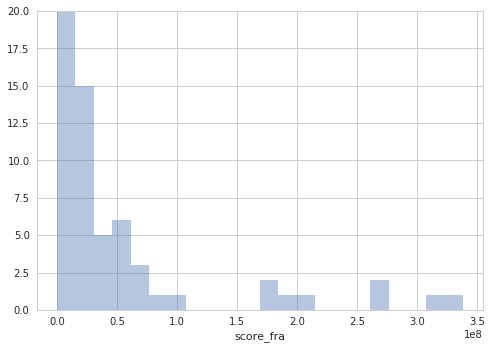

In [317]:
sns.distplot(dfn['score_fra'], kde = 0)
plt.ylim(0,20)
plt.show()

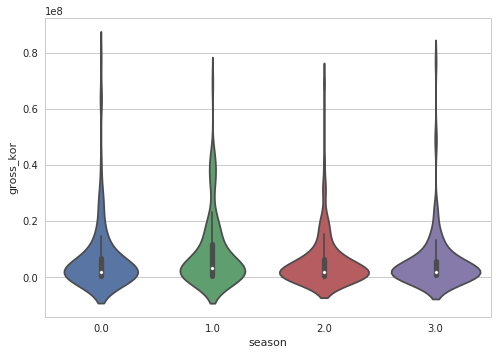

In [318]:
sns.violinplot(y = dfn['gross_kor'], x = dfn['season'])
plt.show()

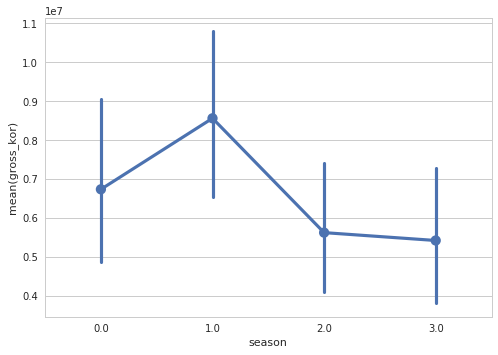

In [319]:
sns.pointplot(x="season", y="gross_kor",  data=dfn, dodge=True)
plt.show()

In [335]:
#장르 더미
genre = [u'\uac00\uc871',
 u'\uc2dc\ub300\uadf9',
 u'\uc2a4\ub9b4\ub7ec',
 u'\ub4dc\ub77c\ub9c8',
 u'\uc560\ub2c8\uba54\uc774\uc158',
 u'\uc804\uc7c1',
 u'\uc5b4\ub4dc\ubca4\ucc98',
 u'\uacf5\ud3ec',
 u'\ud310\ud0c0\uc9c0',
 u'\ubbf8\uc2a4\ud130\ub9ac',
 u'\ub2e4\ud050\uba58\ud130\ub9ac',
 u'\uc11c\ubd80',
 u'\ub85c\ub9e8\uc2a4/\uba5c\ub85c',
 u'\uc561\uc158',
 u'\ubc94\uc8c4',
 u'\ucf54\ubbf8\ub514',
 u'\ubb34\ud611',
 u'SF',
 u'\ubba4\uc9c0\uceec']
dummies = pd.DataFrame(np.zeros((len(dfn), len(genre))), columns=genre)
for i, gen in enumerate(dfn.genre):
    for j in gen:
        dummies.ix[i, j] = 1./len(gen)
gen = np.arange(len(genre))
dummies.columns = gen
dfn = dfn.join(dummies.add_prefix('Genre_'))

In [336]:
#등급 더미
dfgrade = pd.get_dummies(dfn.grade)
del dfgrade[u'']
dfgrade.columns = [12,15,0,18]
dfn = dfn.join(dfgrade)

ValueError: columns overlap but no suffix specified: Index([12, 15, 0, 18], dtype='object')

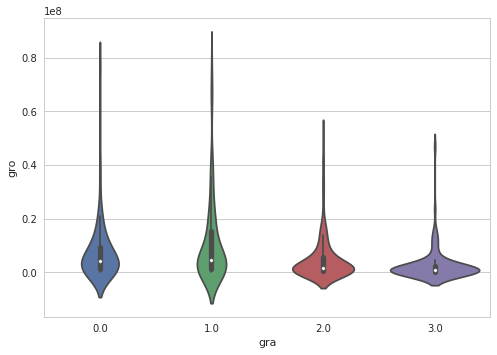

In [337]:
#등급 바이올린 플롯
grades = [u'전체관람가', u'12세이상관람가', u'15세이상관람가', u'청소년관람불가']
dfg2 = pd.DataFrame(np.zeros((len(dfn), 2)), columns=['gra', 'gro'])
for n, gra in enumerate(dfn.grade) :
    if gra != u'':
        idg = grades.index(gra)
        dfg2.ix[n, 'gra'] = idg
        dfg2.ix[n, 'gro'] = dfn.ix[n,'gross_kor']
sns.violinplot(y = dfg2['gro'], x = dfg2['gra'])
plt.show()

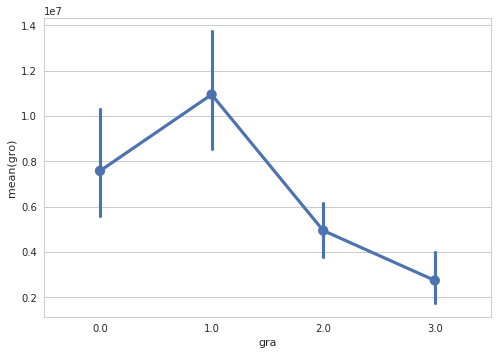

In [338]:
sns.pointplot(x="gra", y="gro",  data=dfg2, dodge=True)
plt.show()

In [339]:
#장르 바이올린 플롯
dfgen = pd.DataFrame(np.zeros((len(dfn), 2)), columns=['genre','gross_kor'])
count = 0
for i, gen in enumerate(dfn.genre):
    for j in gen:
        sel = genre.index(j)
        dfgen.ix[count,'genre'] = sel
        dfgen.ix[count,'gross_kor'] = dfn.ix[i,'gross_kor']
        count += 1

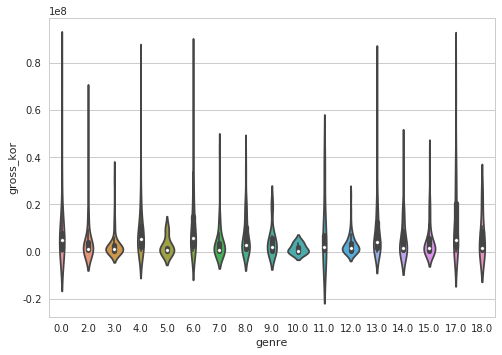

In [340]:
sns.violinplot(y = dfgen['gross_kor'], x = dfgen['genre'])
plt.show()

In [341]:
import sys
for n, i in enumerate(genre):
    sys.stdout.write('%d%s ' %(n,i))

0가족 1시대극 2스릴러 3드라마 4애니메이션 5전쟁 6어드벤처 7공포 8판타지 9미스터리 10다큐멘터리 11서부 12로맨스/멜로 13액션 14범죄 15코미디 16무협 17SF 18뮤지컬 

In [342]:
df_n0 = dfn[dfn['score_dir']!=0].reset_index(drop = 1)
df_n0 = df_n0[df_n0['score_act']!=0].reset_index(drop = 1)

In [373]:
df_n0.ix[:,21:-5].tail()

,Genre_가족,Genre_시대극,Genre_스릴러,Genre_드라마,Genre_애니메이션,Genre_전쟁,Genre_어드벤처,Genre_공포,Genre_판타지,Genre_미스터리,...,Genre_4,Genre_5,Genre_6,Genre_7,Genre_8,Genre_9,Genre_10,Genre_11,Genre_12,Genre_13
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
261,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
262,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [344]:
print(df_n0.describe())

          gross_kor      gross_us  project_budget     score_act     score_dir  \
count  2.650000e+02  2.650000e+02    2.650000e+02  2.650000e+02  2.650000e+02   
mean   8.079298e+06  1.150416e+08    8.982566e+07  1.436185e+08  1.015662e+07   
std    1.217981e+07  1.088429e+08    6.274742e+07  1.739871e+08  1.514861e+07   
min    2.695000e+03  1.632650e+05    1.500000e+06  3.061350e+05  8.960000e+02   
25%    9.893420e+05  4.641204e+07    4.000000e+07  4.955232e+07  1.092781e+06   
50%    3.503340e+06  8.330158e+07    7.500000e+07  9.786806e+07  4.876845e+06   
75%    1.022776e+07  1.484159e+08    1.300000e+08  1.831681e+08  1.469705e+07   
max    7.828683e+07  9.366622e+08    2.500000e+08  1.693858e+09  1.124064e+08   

          score_fra  viewing_time         year        sp_d        su_d  \
count  2.650000e+02    265.000000   265.000000  265.000000  265.000000   
mean   8.057375e+06    117.343396  2012.822642    0.264151    0.252830   
std    3.525738e+07     18.234972     2.013839  

In [287]:
print(df_n0.sum())

gross_kor         2.141014e+09
gross_us          3.048602e+10
project_budget    2.380380e+10
score_act         3.805891e+10
score_dir         2.691504e+09
score_fra         2.135204e+09
viewing_time      3.109600e+04
year              5.333980e+05
sp_d              7.000000e+01
su_d              6.700000e+01
au_d              6.300000e+01
wi_d              6.500000e+01
season            3.880000e+02
Genre_0           4.083333e+00
Genre_1           0.000000e+00
Genre_2           3.466667e+01
Genre_3           3.591667e+01
Genre_4           8.616667e+00
Genre_5           1.500000e+00
Genre_6           2.628333e+01
Genre_7           8.500000e+00
Genre_8           1.553333e+01
Genre_9           3.833333e+00
Genre_10          0.000000e+00
Genre_11          1.500000e+00
Genre_12          1.358333e+01
Genre_13          6.225000e+01
Genre_14          7.333333e+00
Genre_15          1.928333e+01
Genre_16          0.000000e+00
Genre_17          2.058333e+01
Genre_18          1.533333e+00
12      

In [345]:
dfx = pd.DataFrame(df_n0, columns= [ u'project_budget', u'score_act', u'score_dir', u'score_fra',
    u'Genre_0', u'Genre_1', u'Genre_2', u'Genre_3', u'Genre_4', u'Genre_5', u'Genre_6',
    u'Genre_7', u'Genre_8', u'Genre_9', u'Genre_10', u'Genre_11', u'Genre_12',
    u'Genre_13', u'Genre_14', u'Genre_15', u'Genre_16', u'Genre_17', u'Genre_18',
                                    'sp_d','su_d','au_d','wi_d',0,12,15,18])
dfy = pd.DataFrame(df_n0, columns = ['gross_kor'])

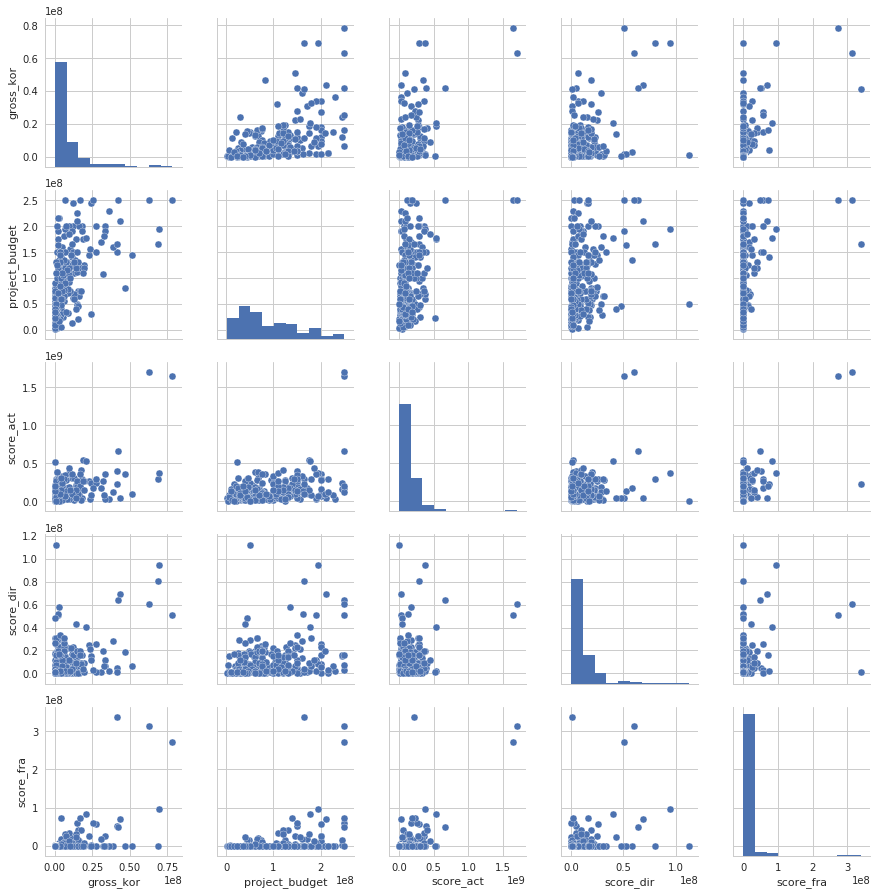

In [346]:
sns.pairplot(df_n0, vars=['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra'])
plt.show()

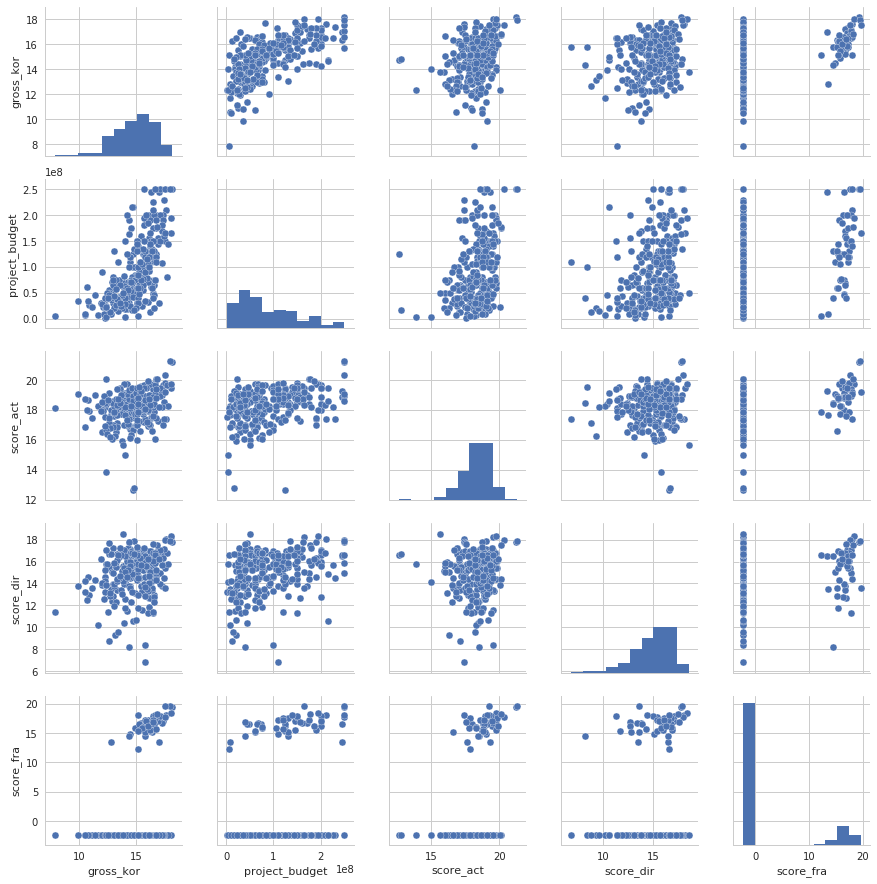

In [347]:
new_dfn = df_n0.ix[:,['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra']]
new_dfn['score_fra'] = np.log(new_dfn['score_fra'] + 0.1)
new_dfn['gross_kor'] = np.log(new_dfn['gross_kor'])
new_dfn['score_act'] = np.log(new_dfn['score_act'])
new_dfn['score_dir'] = np.log(new_dfn['score_dir'])
sns.pairplot(new_dfn)
plt.show()

In [348]:
dfx = sm.add_constant(dfx, has_constant='add')
dfx.columns

Index([         u'const', u'project_budget',      u'score_act',
            u'score_dir',      u'score_fra',        u'Genre_0',
              u'Genre_1',        u'Genre_2',        u'Genre_3',
              u'Genre_4',        u'Genre_5',        u'Genre_6',
              u'Genre_7',        u'Genre_8',        u'Genre_9',
             u'Genre_10',       u'Genre_11',       u'Genre_12',
             u'Genre_13',       u'Genre_14',       u'Genre_15',
             u'Genre_16',       u'Genre_17',       u'Genre_18',
                 u'sp_d',           u'su_d',           u'au_d',
                 u'wi_d',                 0,                12,
                      15,                18],
      dtype='object')

In [349]:
model = sm.OLS( dfy['gross_kor'], dfx)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     12.54
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           1.21e-31
Time:                        17:50:10   Log-Likelihood:                -4584.7
No. Observations:                 265   AIC:                             9223.
Df Residuals:                     238   BIC:                             9320.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const          -7.606e+06   5.13e+06     -1.

In [350]:
#로그변환
#dfx['log_bud'] = np.log(dfx['project_budget'])
dfx['score_act'] = np.log(dfx['score_act'])
dfx['score_dir'] = np.log(dfx['score_dir'])
dfx['score_fra'] = np.log(dfx['score_fra'] + 0.1)
dfy = np.log(dfy)
#del dfx['project_budget']
#del dfx['score_act']
#del dfx['score_dir']
#sns.pairplot(dfx.join(dfy), vars=['project_budget', 'score_act', 'score_dir','gross_kor'])
#plt.show()

In [351]:
model = sm.OLS( dfy, dfx)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     9.750
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           4.13e-25
Time:                        17:50:31   Log-Likelihood:                -419.29
No. Observations:                 265   AIC:                             892.6
Df Residuals:                     238   BIC:                             989.2
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              8.2658      1.442      5.

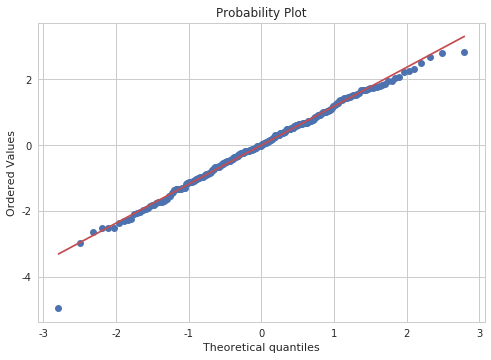

In [352]:
#아웃라이어
plt.figure()
sp.stats.probplot(result.resid, plot = plt)
plt.show()

In [353]:
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(dfx)-2)
idx = np.where(cooks_d2 < fox_cr)[0]
dfx2 = dfx.reset_index(drop = 1).ix[idx,:]
dfy2 = dfy.reset_index(drop = 1).ix[idx, :]

In [354]:
model2 = sm.OLS(dfy2['gross_kor'], dfx2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     11.45
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           2.06e-27
Time:                        17:50:41   Log-Likelihood:                -376.12
No. Observations:                 252   AIC:                             802.2
Df Residuals:                     227   BIC:                             890.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              7.1357      0.952      7.

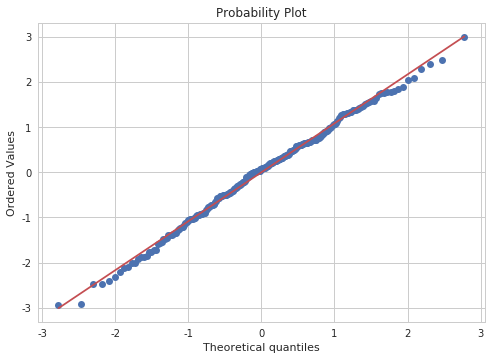

In [355]:
plt.figure()
sp.stats.probplot(result2.resid, plot = plt)
plt.show()

In [366]:
#스케일링
scaler = StandardScaler()
df3 = pd.DataFrame(scaler.fit_transform(dfx2.ix[:, 1:5]), columns=dfx2.columns[1:5])
dfy3 = pd.DataFrame(scaler.fit_transform(dfy2), columns=dfy2.columns)

In [367]:
df3 = df3.join(dfx2.reset_index(drop=1).ix[:,5:-8])
df3 = sm.add_constant(df3,has_constant='add')

In [368]:
model3 = sm.OLS(dfy3.reset_index(drop = 1), df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     14.17
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           2.66e-28
Time:                        17:56:30   Log-Likelihood:                -264.42
No. Observations:                 252   AIC:                             566.8
Df Residuals:                     233   BIC:                             633.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              0.0196      0.175      0.

In [370]:
tmp3 = df3.copy()

In [363]:
df3 = tmp3.copy()

In [371]:
#변수선택
del df3['Genre_0']
del df3['Genre_5']
del df3['Genre_10']
del df3['Genre_11']
del df3['Genre_16']
del df3['Genre_18']
#del df3['score_dir']
#del df3['score_act']
#del df3['project_budget']
del df3['Genre_2']
del df3['Genre_4']
del df3['Genre_6']
del df3['Genre_9']
del df3['Genre_12']
del df3['Genre_13']
del df3['Genre_14']
del df3['Genre_15']
del df3['Genre_17']



In [361]:
df3

,const,score_act,score_dir,score_fra,Genre_1,Genre_3,Genre_7,Genre_8,sp_d,su_d,au_d,wi_d,0,12,15,18
0,1,-0.770773,1.571130,2.166299,0.0,-0.477886,-0.184681,-0.395852,-0.614043,1.696149,-0.546781,-0.559017,-0.40161,1.479822,-0.738926,-0.491304
1,1,1.015773,0.442492,1.928979,0.0,-0.477886,-0.184681,-0.395852,-0.614043,-0.589571,1.828887,-0.559017,-0.40161,-0.675757,1.353315,-0.491304
2,1,1.230153,0.371902,2.033062,0.0,-0.477886,-0.184681,1.744808,1.628550,-0.589571,-0.546781,-0.559017,-0.40161,1.479822,-0.738926,-0.491304
3,1,0.629301,-0.615679,1.984980,0.0,0.414168,-0.184681,-0.395852,-0.614043,1.696149,-0.546781,-0.559017,-0.40161,1.479822,-0.738926,-0.491304
4,1,1.062870,1.651289,-0.501795,0.0,-0.477886,-0.184681,-0.395852,-0.614043,-0.589571,1.828887,-0.559017,-0.40161,1.479822,-0.738926,-0.491304
5,1,0.984388,1.049954,2.033651,0.0,-0.477886,-0.184681,-0.395852,-0.614043,1.696149,-0.546781,-0.559017,2.48998,-0.675757,-0.738926,-0.491304
6,1,-1.314481,-0.613485,-0.501795,0.0,1.306221,-0.184681,-0.395852,-0.614043,-0.589571,-0.546781,1.788854,-0.40161,-0.675757,-0.738926,2.035401
7,1,0.926322,0.552176,-0.501795,0.0,-0.477886,-0.184681,-0.395852,1.628550,-0.589571,-0.546781,-0.559017,2.48998,-0.675757,-0.738926,-0.491304
8,1,-4.894038,0.806317,-0.501795,0.0,-0.477886,-0.184681,-0.395852,-0.614043,1.696149,-0.546781,-0.559017,-0.40161,1.479822,-0.738926,-0.491304
9,1,1.279609,0.931621,-0.501795,0.0,-0.477886,-0.184681,-0.395852,-0.614043,-0.589571,-0.546781,1.788854,2.48998,-0.675757,-0.738926,-0.491304


In [372]:
model3 = sm.OLS(dfy2.reset_index(drop = 1), df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     35.85
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           3.21e-34
Time:                        17:56:54   Log-Likelihood:                -386.94
No. Observations:                 252   AIC:                             789.9
Df Residuals:                     244   BIC:                             818.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             15.0071      0.090    167.

In [275]:
dfx = pd.DataFrame(df_n0, columns= [ u'project_budget', u'score_act', u'score_dir', u'score_fra',
    u'Genre_0', u'Genre_1', u'Genre_2', u'Genre_3', u'Genre_4', u'Genre_5', u'Genre_6',
    u'Genre_7', u'Genre_8', u'Genre_9', u'Genre_10', u'Genre_11', u'Genre_12',
    u'Genre_13', u'Genre_14', u'Genre_15', u'Genre_16', u'Genre_17', u'Genre_18',
                                    'sp_d','su_d','au_d','wi_d',0,12,15,18])
dfy = pd.DataFrame(df_n0, columns = ['gross_kor'])

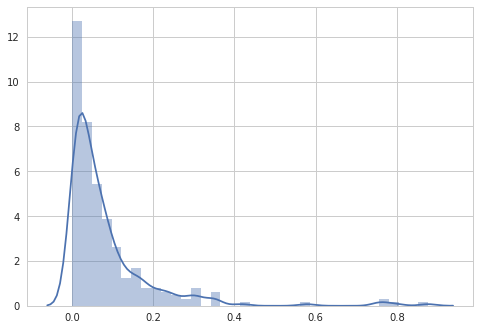

In [276]:
#Y값을 제작비 대비 매출로.
dfy_r = pd.DataFrame(dfy['gross_kor'] / dfx['project_budget'], columns=['ratio'])
del dfx['project_budget']
sns.distplot(dfy_r)
plt.show()

In [277]:
dfy_r = dfy_r.dropna()

In [278]:
model3 = sm.OLS(dfy_r, dfx)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     2.609
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           9.33e-05
Time:                        16:43:50   Log-Likelihood:                 212.41
No. Observations:                 265   AIC:                            -372.8
Df Residuals:                     239   BIC:                            -279.7
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
score_act   6.045e-11   5.69e-11      1.062      0.2

In [279]:
#로그변환
#dfx['log_bud'] = np.log(dfx['project_budget'])
dfx['score_act'] = np.log(dfx['score_act'])
dfx['score_dir'] = np.log(dfx['score_dir'])
dfx['score_fra'] = np.log(dfx['score_fra']+0.1)
dfy_r = np.log(dfy_r)
#del dfx['project_budget']
#del dfx['score_act']
#del dfx['score_dir']
#sns.pairplot(dfx.join(dfy_r), vars=['score_act', 'score_dir','ratio'])
#plt.show()

In [280]:
model3 = sm.OLS(dfy_r, dfx)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2.873
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           1.62e-05
Time:                        16:43:53   Log-Likelihood:                -411.40
No. Observations:                 265   AIC:                             874.8
Df Residuals:                     239   BIC:                             967.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
score_act      0.0370      0.074      0.501      0.6

In [281]:
tmp = dfx.copy()

In [282]:
del dfx['score_fra']
del dfx['Genre_0']
del dfx['Genre_1']
del dfx['Genre_6']
del dfx['Genre_7']
del dfx['Genre_9']
del dfx['Genre_10']
del dfx['Genre_12']
del dfx['Genre_14']
del dfx['Genre_16']
del dfx[0]
del dfx[12]
del dfx[15]
del dfx[18]
del dfx['Genre_4']
del dfx['Genre_5']
del dfx['Genre_8']
del dfx['Genre_13']
del dfx['Genre_18']
del dfx['sp_d']
del dfx['au_d']

In [283]:
dfx2 = pd.DataFrame(scaler.fit_transform(dfx.ix[:, 0:3]), columns=dfx.columns[0:3])
dfy2 = pd.DataFrame(scaler.fit_transform(dfy), columns=dfy.columns)
dfx2 = dfx2.join(dfx.reset_index(drop=1).ix[:,3:])

In [284]:
model3 = sm.OLS(dfy2, dfx2)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     9.920
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           4.81e-13
Time:                        16:44:01   Log-Likelihood:                -336.38
No. Observations:                 265   AIC:                             690.8
Df Residuals:                     256   BIC:                             723.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
score_act      0.2977      0.055      5.436      0.0